In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-limpio/preprocessing_objects.pkl
/kaggle/input/archivoss/submission_example.csv
/kaggle/input/archivoss/test.csv
/kaggle/input/datos-limpios/train_cleaned.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Cargar datos preprocesados del Notebook 02
print("=" * 70)
print("CARGANDO DATOS PREPROCESADOS DEL NOTEBOOK 02")
print("=" * 70)

import pandas as pd
import numpy as np
import joblib
import os

# Cargar train_cleaned.csv directamente
train_cleaned_path = '/kaggle/input/datos-limpios/train_cleaned.csv'
preprocessing_path = '/kaggle/input/train-limpio/preprocessing_objects.pkl'

if os.path.exists(train_cleaned_path):
    train = pd.read_csv(train_cleaned_path)
    print(f"✓ train_cleaned.csv cargado desde: {train_cleaned_path}")
    print(f"   Forma: {train.shape}")
    print(f"   Columnas: {len(train.columns)}")
    print(f"   Valores faltantes: {train.isnull().sum().sum()}")
    print(f"\nPrimeras columnas: {train.columns.tolist()[:10]}")
else:
    print(f"❌ No se encontró: {train_cleaned_path}")
    print("   Verifica que el archivo esté disponible")

# Cargar objetos de preprocesado (por si los necesitas para test.csv después)
if os.path.exists(preprocessing_path):
    preprocessing_objects = joblib.load(preprocessing_path)
    print(f"\n✓ preprocessing_objects.pkl cargado desde: {preprocessing_path}")
    
    numeric_imputer = preprocessing_objects.get('numeric_imputer')
    categorical_imputer = preprocessing_objects.get('categorical_imputer')
    label_encoders = preprocessing_objects.get('label_encoders', {})
    numeric_cols_clean = preprocessing_objects.get('numeric_cols', [])
    categorical_cols_clean = preprocessing_objects.get('categorical_cols', [])
    
    print(f"   Objetos cargados para usar en test.csv:")
    print(f"   - numeric_imputer: {'✓' if numeric_imputer is not None else '✗'}")
    print(f"   - categorical_imputer: {'✓' if categorical_imputer is not None else '✗'}")
    print(f"   - label_encoders: {len(label_encoders)} columnas")
else:
    print(f"\n⚠ No se encontró: {preprocessing_path}")
    numeric_imputer = None
    categorical_imputer = None
    label_encoders = {}
    numeric_cols_clean = []
    categorical_cols_clean = []

# Verificación final
if 'train' in locals() and train is not None:
    print(f"\n" + "=" * 70)
    print("✓ DATOS LISTOS PARA USAR")
    print("=" * 70)
    print(f"\nDataset cargado exitosamente")
    print(f"   Forma: {train.shape}")
    print(f"   Total columnas: {len(train.columns)}")
    print(f"\nTodas las columnas:")
    for i, col in enumerate(train.columns, 1):
        print(f"   {i:2d}. {col}")
else:
    print("\n❌ ERROR: No se pudo cargar train_cleaned.csv")

CARGANDO DATOS PREPROCESADOS DEL NOTEBOOK 02
✓ train_cleaned.csv cargado desde: /kaggle/input/datos-limpios/train_cleaned.csv
   Forma: (692500, 21)
   Columnas: 21
   Valores faltantes: 297378

Primeras columnas: ['ID', 'PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA']

✓ preprocessing_objects.pkl cargado desde: /kaggle/input/train-limpio/preprocessing_objects.pkl
   Objetos cargados para usar en test.csv:
   - numeric_imputer: ✓
   - categorical_imputer: ✓
   - label_encoders: 15 columnas

✓ DATOS LISTOS PARA USAR

Dataset cargado exitosamente
   Forma: (692500, 21)
   Total columnas: 21

Todas las columnas:
    1. ID
    2. PERIODO_ACADEMICO
    3. E_PRGM_ACADEMICO
    4. E_PRGM_DEPARTAMENTO
    5. E_VALORMATRICULAUNIVERSIDAD
    6. E_HORASSEMANATRABAJA
    7. F_ESTRATOVIVIENDA
    8. F_TIENEINTERNET
    9. F_EDUCACIONPADRE
   10. F_TIEN

In [4]:
print("=" * 70)
print("IDENTIFICANDO COLUMNA OBJETIVO")
print("=" * 70)

# Estrategia: buscar columnas que parecen ser objetivo
# (últimas columnas, o con nombres comunes, o con pocos valores únicos)

possible_targets = []

# 1. Buscar por nombres comunes
target_keywords = ['target', 'label', 'class', 'y', 'outcome', 'result', 'prediction', 
                   'indicador', 'rendimiento', 'score', 'rating']

for col in train.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in target_keywords):
        possible_targets.append(col)

# 2. Si no se encontró, usar la última columna (común en competencias)
if len(possible_targets) == 0:
    # Excluir ID si existe
    candidate_cols = [col for col in train.columns if col.upper() != 'ID']
    if len(candidate_cols) > 0:
        possible_targets.append(candidate_cols[-1])  # Última columna

# 3. Mostrar opciones y seleccionar automáticamente la más probable
if len(possible_targets) > 0:
    target_col = possible_targets[0]  # Usar la primera encontrada
    print(f"✓ Columna objetivo detectada: '{target_col}'")
    
    # Separar X e y (excluir ID si existe)
    cols_to_drop = [target_col]
    if 'ID' in train.columns:
        cols_to_drop.append('ID')
    
    X = train.drop(columns=cols_to_drop)
    y = train[target_col]
    
    print(f"\nX (características): {X.shape}")
    print(f"y (objetivo): {y.shape}")
    print(f"\nDistribución de y:")
    print(y.value_counts().head(20))
    
    # Verificar si es clasificación o regresión
    unique_values = y.nunique()
    print(f"\nValores únicos en y: {unique_values}")
    if unique_values < 20:
        print("→ Problema de CLASIFICACIÓN")
        problem_type = 'classification'
    else:
        print("→ Problema de REGRESIÓN")
        print("⚠️ Usando RandomForestClassifier. Si es regresión, cambia a RandomForestRegressor")
        problem_type = 'regression'
else:
    print("⚠ No se pudo detectar columna objetivo automáticamente.")
    print("\nColumnas disponibles:")
    for i, col in enumerate(train.columns, 1):
        print(f"  {i}. {col}")
    print("\nPor favor, especifica manualmente:")
    print("  target_col = 'nombre_columna'")

IDENTIFICANDO COLUMNA OBJETIVO
✓ Columna objetivo detectada: 'RENDIMIENTO_GLOBAL'

X (características): (692500, 19)
y (objetivo): (692500,)

Distribución de y:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64

Valores únicos en y: 4
→ Problema de CLASIFICACIÓN


In [5]:
# FEATURE ENGINEERING GENERAL
print("=" * 70)
print("FEATURE ENGINEERING")
print("=" * 70)

X_fe = X.copy()
features_creadas = 0

# Identificar columnas numéricas
numeric_cols = X_fe.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Columnas numéricas: {len(numeric_cols)}")
print(f"Columnas categóricas: {len(categorical_cols)}")

# 1. Estadísticas por fila (para todas las numéricas)
if len(numeric_cols) > 0:
    X_fe['row_mean'] = X_fe[numeric_cols].mean(axis=1)
    X_fe['row_std'] = X_fe[numeric_cols].std(axis=1)
    X_fe['row_max'] = X_fe[numeric_cols].max(axis=1)
    X_fe['row_min'] = X_fe[numeric_cols].min(axis=1)
    X_fe['row_median'] = X_fe[numeric_cols].median(axis=1)
    X_fe['row_range'] = X_fe['row_max'] - X_fe['row_min']
    features_creadas += 6
    print(f"✓ Estadísticas por fila creadas: 6")

# 2. Interacciones entre las primeras 5 características numéricas más importantes
if len(numeric_cols) >= 2:
    top_numeric = numeric_cols[:min(5, len(numeric_cols))]
    interacciones = 0
    for i, col1 in enumerate(top_numeric):
        for col2 in top_numeric[i+1:]:
            X_fe[f"{col1}_x_{col2}"] = X_fe[col1] * X_fe[col2]
            interacciones += 1
    features_creadas += interacciones
    print(f"✓ Interacciones creadas: {interacciones}")

# 3. Transformaciones polinómicas (primeras 3 numéricas)
if len(numeric_cols) >= 1:
    top_3_numeric = numeric_cols[:min(3, len(numeric_cols))]
    for col in top_3_numeric:
        X_fe[f"{col}_squared"] = X_fe[col] ** 2
        X_fe[f"{col}_sqrt"] = np.sqrt(np.abs(X_fe[col]))
        features_creadas += 2
    print(f"✓ Transformaciones polinómicas creadas: {len(top_3_numeric) * 2}")

# 4. Interacciones entre columnas binarias (0/1) si existen
binary_cols = []
for col in X_fe.columns:
    if X_fe[col].nunique() == 2 and set(X_fe[col].unique()).issubset({0, 1}):
        binary_cols.append(col)

if len(binary_cols) >= 2:
    # Crear interacciones entre las primeras 5 binarias
    top_binary = binary_cols[:min(5, len(binary_cols))]
    binary_interactions = 0
    for i, col1 in enumerate(top_binary):
        for col2 in top_binary[i+1:]:
            X_fe[f"{col1}_AND_{col2}"] = X_fe[col1] * X_fe[col2]
            binary_interactions += 1
    features_creadas += binary_interactions
    print(f"✓ Interacciones binarias creadas: {binary_interactions}")

# 5. Estadísticas de grupos si hay columnas categóricas codificadas
# (agrupaciones por categorías)
if len(categorical_cols) == 0 and len(numeric_cols) > 0:
    # Si todas están codificadas, buscar columnas con pocos valores únicos que puedan ser categóricas
    low_cardinality_cols = []
    for col in numeric_cols:
        if X_fe[col].nunique() < 20 and X_fe[col].nunique() < len(X_fe) * 0.1:
            low_cardinality_cols.append(col)
    
    if len(low_cardinality_cols) > 0:
        # Agrupar por la primera columna de baja cardinalidad y calcular estadísticas
        group_col = low_cardinality_cols[0]
        for num_col in numeric_cols[:3]:  # Primeras 3 numéricas
            if num_col != group_col:
                group_stats = X_fe.groupby(group_col)[num_col].agg(['mean', 'std']).reset_index()
                group_stats.columns = [group_col, f'{num_col}_group_mean', f'{num_col}_group_std']
                X_fe = X_fe.merge(group_stats, on=group_col, how='left')
                features_creadas += 2
        print(f"✓ Estadísticas por grupo creadas")

# Rellenar cualquier NaN creado
X_fe = X_fe.fillna(0)

X = X_fe.copy()
print(f"\n✓ Feature engineering completado")
print(f"   Características originales: {len(train.columns) - len(cols_to_drop)}")
print(f"   Nuevas características creadas: {features_creadas}")
print(f"   Total características: {X.shape[1]}")

# Asegurar que todas las columnas sean numéricas
print(f"\n📊 Verificando tipos de datos...")
non_numeric = []
for col in X_fe.columns:
    if X_fe[col].dtype == 'object' or X_fe[col].dtype.name == 'category':
        non_numeric.append(col)

if len(non_numeric) > 0:
    print(f"   ⚠ Columnas no numéricas encontradas: {len(non_numeric)}")
    from sklearn.preprocessing import LabelEncoder
    for col in non_numeric:
        le = LabelEncoder()
        X_fe[col] = le.fit_transform(X_fe[col].astype(str))
        print(f"   ✓ {col} codificada")
else:
    print(f"   ✓ Todas las columnas son numéricas")

# Rellenar NaN e infinitos
X_fe = X_fe.replace([np.inf, -np.inf], 0)
X_fe = X_fe.fillna(0)

X = X_fe.copy()
print(f"\n✓ Feature engineering completado")
print(f"   Total características: {X.shape[1]}")
print(f"   Todas numéricas: {len(X.select_dtypes(include=[np.number]).columns) == len(X.columns)}")

FEATURE ENGINEERING
Columnas numéricas: 5
Columnas categóricas: 14
✓ Estadísticas por fila creadas: 6
✓ Interacciones creadas: 10
✓ Transformaciones polinómicas creadas: 6

✓ Feature engineering completado
   Características originales: 19
   Nuevas características creadas: 22
   Total características: 41

📊 Verificando tipos de datos...
   ⚠ Columnas no numéricas encontradas: 14
   ✓ E_PRGM_ACADEMICO codificada
   ✓ E_PRGM_DEPARTAMENTO codificada
   ✓ E_VALORMATRICULAUNIVERSIDAD codificada
   ✓ E_HORASSEMANATRABAJA codificada
   ✓ F_ESTRATOVIVIENDA codificada
   ✓ F_TIENEINTERNET codificada
   ✓ F_EDUCACIONPADRE codificada
   ✓ F_TIENELAVADORA codificada
   ✓ F_TIENEAUTOMOVIL codificada
   ✓ E_PRIVADO_LIBERTAD codificada
   ✓ E_PAGOMATRICULAPROPIO codificada
   ✓ F_TIENECOMPUTADOR codificada
   ✓ F_TIENEINTERNET.1 codificada
   ✓ F_EDUCACIONMADRE codificada

✓ Feature engineering completado
   Total características: 41
   Todas numéricas: True


In [6]:
# Dividir en entrenamiento y validación
print("=" * 70)
print("DIVIDIENDO DATOS EN ENTRENAMIENTO Y VALIDACIÓN")
print("=" * 70)

from sklearn.model_selection import train_test_split

# Intentar con stratify, si falla usar sin stratify
try:
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    print("✓ División realizada con stratify")
except ValueError:
    # Si falla (por ejemplo, en regresión), dividir sin stratify
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
    print("✓ División realizada sin stratify")

print(f"\nConjunto de entrenamiento: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Conjunto de validación: {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X)*100:.1f}%)")

print(f"\nDistribución en entrenamiento:")
print(y_train.value_counts().head(10))

print(f"\nDistribución en validación:")
print(y_val.value_counts().head(10))

DIVIDIENDO DATOS EN ENTRENAMIENTO Y VALIDACIÓN
✓ División realizada con stratify

Conjunto de entrenamiento: 554,000 muestras (80.0%)
Conjunto de validación: 138,500 muestras (20.0%)

Distribución en entrenamiento:
RENDIMIENTO_GLOBAL
alto          140495
bajo          138390
medio-bajo    137820
medio-alto    137295
Name: count, dtype: int64

Distribución en validación:
RENDIMIENTO_GLOBAL
alto          35124
bajo          34597
medio-bajo    34455
medio-alto    34324
Name: count, dtype: int64


In [7]:
# Verificar y convertir todas las columnas a numéricas
print("=" * 70)
print("VERIFICANDO Y CONVIRTIENDO COLUMNAS A NUMÉRICAS")
print("=" * 70)

# Identificar columnas que no son numéricas
non_numeric_cols = []
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category':
        non_numeric_cols.append(col)

if len(non_numeric_cols) > 0:
    print(f"\n⚠ Encontradas {len(non_numeric_cols)} columnas no numéricas:")
    for col in non_numeric_cols:
        print(f"   - {col}: {X[col].dtype}, valores únicos: {X[col].nunique()}")
    
    print(f"\n📊 Codificando columnas categóricas restantes...")
    
    # Codificar todas las columnas categóricas que queden
    from sklearn.preprocessing import LabelEncoder
    
    label_encoders_fe = {}
    for col in non_numeric_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders_fe[col] = le
        print(f"   ✓ {col} codificada: {X[col].nunique()} valores únicos")
    
    print(f"\n✓ Todas las columnas categóricas codificadas")
else:
    print(f"\n✓ Todas las columnas ya son numéricas")

# Verificar que todas las columnas sean numéricas ahora
numeric_cols_final = X.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_final = [col for col in X.columns if col not in numeric_cols_final]

if len(non_numeric_final) > 0:
    print(f"\n⚠ Aún quedan columnas no numéricas: {non_numeric_final}")
    print("   Convirtiendo a numérico...")
    for col in non_numeric_final:
        try:
            X[col] = pd.to_numeric(X[col], errors='coerce')
            X[col] = X[col].fillna(0)
        except:
            # Si falla, usar LabelEncoder
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))

# Verificación final
print(f"\n✓ Verificación final:")
print(f"   Total columnas: {len(X.columns)}")
print(f"   Columnas numéricas: {len(X.select_dtypes(include=[np.number]).columns)}")
print(f"   Columnas no numéricas: {len([c for c in X.columns if X[c].dtype == 'object'])}")

# Verificar que no haya valores infinitos o NaN problemáticos
print(f"\nValores infinitos: {(np.isinf(X.select_dtypes(include=[np.number]))).sum().sum()}")
print(f"Valores NaN: {X.isnull().sum().sum()}")

# Rellenar cualquier NaN o infinito
X = X.replace([np.inf, -np.inf], 0)
X = X.fillna(0)

print(f"\n✓ Dataset listo para entrenar")
print(f"   X: {X.shape}")
print(f"   Tipos de datos: {X.dtypes.value_counts()}")

VERIFICANDO Y CONVIRTIENDO COLUMNAS A NUMÉRICAS

✓ Todas las columnas ya son numéricas

✓ Verificación final:
   Total columnas: 41
   Columnas numéricas: 41
   Columnas no numéricas: 0

Valores infinitos: 0
Valores NaN: 0

✓ Dataset listo para entrenar
   X: (692500, 41)
   Tipos de datos: float64    25
int64      16
Name: count, dtype: int64


In [8]:
# Entrenar modelo Random Forest base
print("=" * 70)
print("ENTRENANDO MODELO RANDOM FOREST BASE")
print("=" * 70)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Verificación final antes de entrenar
print(f"\n📊 Verificación antes de entrenar:")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_train tipos: {X_train.dtypes.value_counts()}")
print(f"   Valores NaN en X_train: {X_train.isnull().sum().sum()}")
print(f"   Valores infinitos en X_train: {(np.isinf(X_train.select_dtypes(include=[np.number]))).sum().sum() if len(X_train.select_dtypes(include=[np.number]).columns) > 0 else 0}")

# Asegurar que X_train sea completamente numérico
X_train = X_train.select_dtypes(include=[np.number])
X_val = X_val.select_dtypes(include=[np.number])

# Asegurar que tengan las mismas columnas
common_cols = list(set(X_train.columns) & set(X_val.columns))
X_train = X_train[common_cols]
X_val = X_val[common_cols]

print(f"\n   Después de filtrar:")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_val shape: {X_val.shape}")

# Determinar si usar class_weight
use_class_weight = 'balanced' if problem_type == 'classification' and y.nunique() > 1 else None

rf_base = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight=use_class_weight,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n⏳ Entrenando modelo base (esto puede tomar varios minutos)...")
rf_base.fit(X_train, y_train)

# Evaluar modelo base
y_pred_val_base = rf_base.predict(X_val)

accuracy_val_base = accuracy_score(y_val, y_pred_val_base)
f1_base = f1_score(y_val, y_pred_val_base, average='weighted') if problem_type == 'classification' else None

print(f"\n✓ Modelo base entrenado")
print(f"\n📊 RESULTADOS:")
print(f"   Accuracy validación: {accuracy_val_base:.4f} ({accuracy_val_base*100:.2f}%)")
if f1_base:
    print(f"   F1-Score validación: {f1_base:.4f}")

ENTRENANDO MODELO RANDOM FOREST BASE

📊 Verificación antes de entrenar:
   X_train shape: (554000, 41)
   X_train tipos: float64    25
int64      16
Name: count, dtype: int64
   Valores NaN en X_train: 0
   Valores infinitos en X_train: 0

   Después de filtrar:
   X_train shape: (554000, 41)
   X_val shape: (138500, 41)

⏳ Entrenando modelo base (esto puede tomar varios minutos)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.2s finished



✓ Modelo base entrenado

📊 RESULTADOS:
   Accuracy validación: 0.4036 (40.36%)
   F1-Score validación: 0.3882


In [9]:
# SALTAR OPTIMIZACIÓN Y USAR MODELO MEJORADO DIRECTAMENTE
print("=" * 70)
print("ENTRENANDO MODELO MEJORADO (SIN OPTIMIZACIÓN)")
print("=" * 70)
print("\n⏳ Entrenando modelo con parámetros mejorados directamente...")
print("   (Más rápido que GridSearch)")

from sklearn.ensemble import RandomForestClassifier

# Modelo con parámetros que generalmente funcionan bien
rf_optimized = RandomForestClassifier(
    n_estimators=300,           # Más árboles
    max_depth=25,               # Más profundidad
    min_samples_split=2,         # Menos restricciones
    min_samples_leaf=1,          # Menos restricciones
    max_features='sqrt',         # Mejor para evitar overfitting
    class_weight='balanced' if problem_type == 'classification' else None,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_optimized.fit(X_train, y_train)

print(f"\n✓ Modelo entrenado")
print(f"\nParámetros usados:")
print(f"   n_estimators: 300")
print(f"   max_depth: 25")
print(f"   min_samples_split: 2")
print(f"   min_samples_leaf: 1")
print(f"   class_weight: {'balanced' if problem_type == 'classification' else None}")

# Evaluar
from sklearn.metrics import accuracy_score, f1_score
y_pred_opt = rf_optimized.predict(X_val)
accuracy_opt = accuracy_score(y_val, y_pred_opt)
f1_opt = f1_score(y_val, y_pred_opt, average='weighted') if problem_type == 'classification' else None

print(f"\n📊 RESULTADOS:")
print(f"   Accuracy validación: {accuracy_opt:.4f} ({accuracy_opt*100:.2f}%)")
if f1_opt:
    print(f"   F1-Score: {f1_opt:.4f}")

ENTRENANDO MODELO MEJORADO (SIN OPTIMIZACIÓN)

⏳ Entrenando modelo con parámetros mejorados directamente...
   (Más rápido que GridSearch)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.



✓ Modelo entrenado

Parámetros usados:
   n_estimators: 300
   max_depth: 25
   min_samples_split: 2
   min_samples_leaf: 1
   class_weight: balanced


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   10.3s finished



📊 RESULTADOS:
   Accuracy validación: 0.3960 (39.60%)
   F1-Score: 0.3857


EVALUACIÓN DEL MODELO
⚠ Usando modelo base (optimización no completada)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.1s finished



RESULTADOS

Accuracy validación: 0.4036 (40.36%)
F1-Score: 0.3882

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        alto       0.49      0.60      0.54     35124
        bajo       0.42      0.54      0.47     34597
  medio-alto       0.31      0.20      0.25     34324
  medio-bajo       0.32      0.26      0.29     34455

    accuracy                           0.40    138500
   macro avg       0.39      0.40      0.39    138500
weighted avg       0.39      0.40      0.39    138500


Matriz de confusión:
[[21240  4130  5612  4142]
 [ 4223 18603  4402  7369]
 [10892  8799  7035  7598]
 [ 6559 12928  5942  9026]]


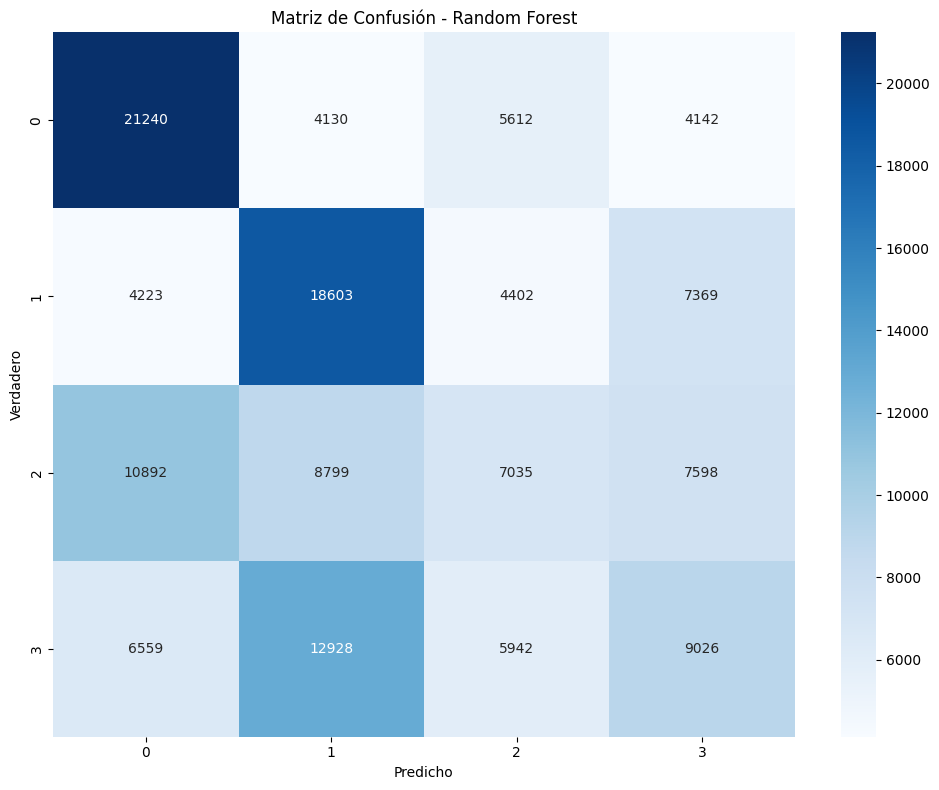

In [10]:
# Evaluar modelo optimizado
print("=" * 70)
print("EVALUACIÓN DEL MODELO")
print("=" * 70)

from sklearn.metrics import classification_report, confusion_matrix

# Usar el modelo optimizado si existe, sino el base
if 'grid_search' in locals() and hasattr(grid_search, 'best_estimator_'):
    rf_optimized = grid_search.best_estimator_
    print("✓ Usando modelo optimizado")
else:
    rf_optimized = rf_base
    print("⚠ Usando modelo base (optimización no completada)")

# Realizar predicciones
y_pred_opt = rf_optimized.predict(X_val)

# Calcular métricas
accuracy_opt = accuracy_score(y_val, y_pred_opt)
f1_opt = f1_score(y_val, y_pred_opt, average='weighted') if problem_type == 'classification' else None

# Mostrar resultados
print("\n" + "=" * 70)
print("RESULTADOS")
print("=" * 70)
print(f"\nAccuracy validación: {accuracy_opt:.4f} ({accuracy_opt*100:.2f}%)")
if f1_opt:
    print(f"F1-Score: {f1_opt:.4f}")

# Reporte de clasificación
if problem_type == 'classification':
    print(f"\n📋 REPORTE DE CLASIFICACIÓN:")
    print(classification_report(y_val, y_pred_opt))
    
    # Matriz de confusión
    cm = confusion_matrix(y_val, y_pred_opt)
    print(f"\nMatriz de confusión:")
    print(cm)
    
    # Visualización
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión - Random Forest')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()

IMPORTANCIA DE CARACTERÍSTICAS

Top 20 características más importantes:
                            feature  importance
29      E_VALORMATRICULAUNIVERSIDAD    0.146952
8                  E_PRGM_ACADEMICO    0.074020
14        INDICADOR_1_x_INDICADOR_3    0.041578
11            E_PAGOMATRICULAPROPIO    0.037987
30                 F_EDUCACIONMADRE    0.037414
3   PERIODO_ACADEMICO_x_INDICADOR_1    0.034812
36              E_PRGM_DEPARTAMENTO    0.033038
27              INDICADOR_1_squared    0.032873
21        INDICADOR_2_x_INDICADOR_4    0.030526
28                 F_EDUCACIONPADRE    0.030047
25        INDICADOR_1_x_INDICADOR_4    0.029417
13                      INDICADOR_1    0.026610
22                 INDICADOR_1_sqrt    0.026578
26                         row_mean    0.025958
18        INDICADOR_2_x_INDICADOR_3    0.025877
40        INDICADOR_3_x_INDICADOR_4    0.024793
32  PERIODO_ACADEMICO_x_INDICADOR_2    0.024757
10             E_HORASSEMANATRABAJA    0.024477
17        INDICA

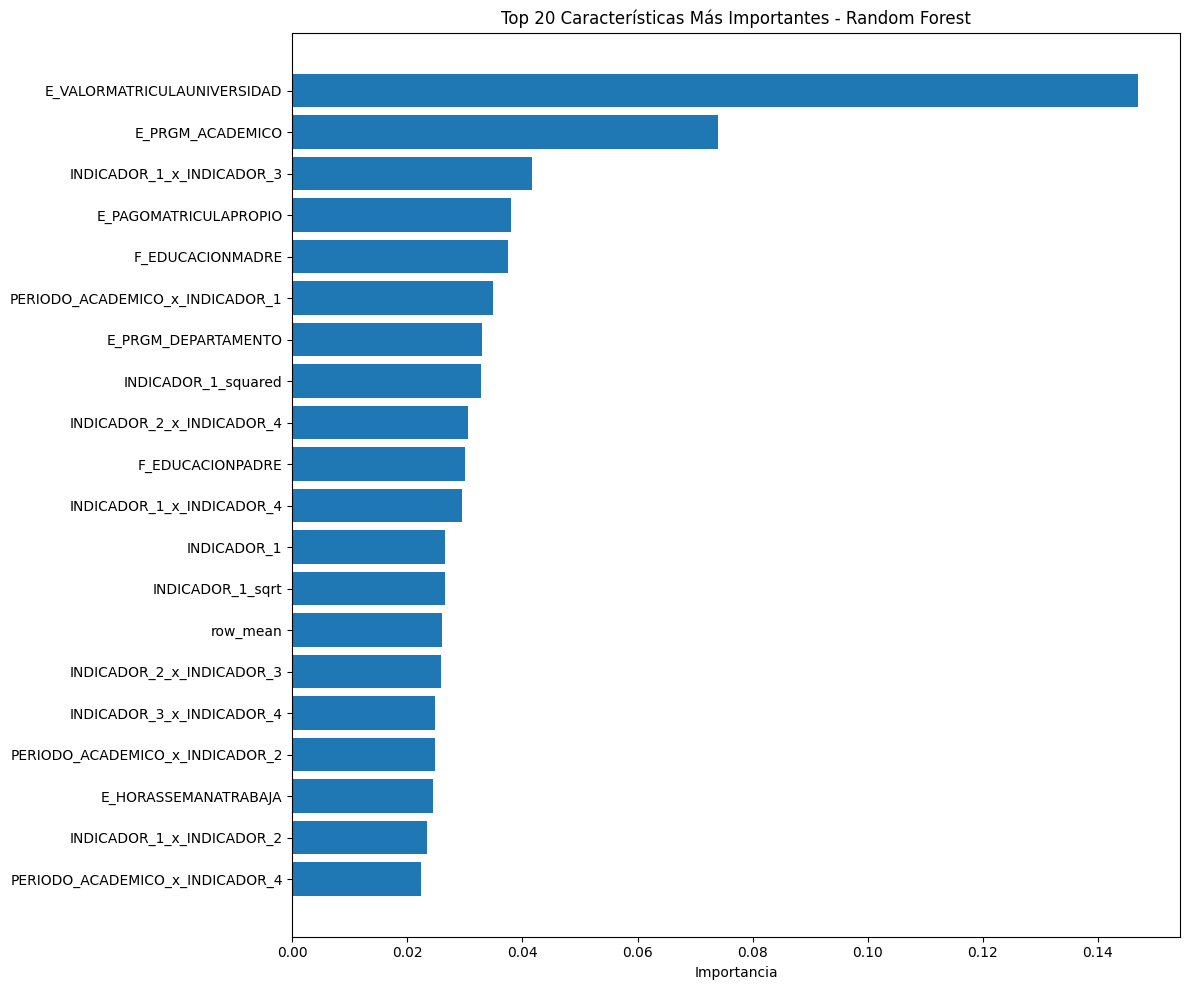

In [11]:
# Importancia de características
print("=" * 70)
print("IMPORTANCIA DE CARACTERÍSTICAS")
print("=" * 70)

# Usar el modelo final seleccionado
if 'rf_final' in locals():
    modelo_para_importancia = rf_final
elif 'rf_optimized' in locals():
    modelo_para_importancia = rf_optimized
else:
    modelo_para_importancia = rf_base

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': modelo_para_importancia.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 características más importantes:")
print(feature_importance.head(20))

plt.figure(figsize=(12, 10))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Características Más Importantes - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
# Cargar datos de test
print("=" * 70)
print("CARGANDO DATOS DE TEST")
print("=" * 70)

# Rutas específicas
test_path = '/kaggle/input/archivoss/test.csv'
submission_example_path = '/kaggle/input/archivoss/submission_example.csv'

if os.path.exists(test_path):
    test = pd.read_csv(test_path)
    print(f"✓ test.csv cargado desde: {test_path}")
    print(f"   Forma: {test.shape}")
    print(f"   Columnas: {test.columns.tolist()}")
else:
    print(f"❌ No se encontró: {test_path}")

# Cargar submission_example para ver el formato requerido
if os.path.exists(submission_example_path):
    submission_example = pd.read_csv(submission_example_path)
    print(f"\n✓ submission_example.csv cargado")
    print(f"   Forma: {submission_example.shape}")
    print(f"   Columnas: {submission_example.columns.tolist()}")
    print(f"\nPrimeras filas del ejemplo:")
    print(submission_example.head())
    print(f"\nEste es el formato que debe tener tu submission")
else:
    print(f"\n⚠ No se encontró submission_example.csv")

CARGANDO DATOS DE TEST
✓ test.csv cargado desde: /kaggle/input/archivoss/test.csv
   Forma: (296786, 20)
   Columnas: ['ID', 'PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']

✓ submission_example.csv cargado
   Forma: (296786, 2)
   Columnas: ['ID', 'RENDIMIENTO_GLOBAL']

Primeras filas del ejemplo:
       ID RENDIMIENTO_GLOBAL
0  550236         medio-bajo
1   98545         medio-bajo
2  499179         medio-alto
3  782980               alto
4  785185         medio-bajo

Este es el formato que debe tener tu submission


In [13]:
# Cargar datos de test
print("=" * 70)
print("CARGANDO DATOS DE TEST")
print("=" * 70)

# Rutas específicas
test_path = '/kaggle/input/archivoss/test.csv'
submission_example_path = '/kaggle/input/archivoss/submission_example.csv'

if os.path.exists(test_path):
    test = pd.read_csv(test_path)
    print(f"✓ test.csv cargado desde: {test_path}")
    print(f"   Forma: {test.shape}")
    print(f"   Columnas: {test.columns.tolist()}")
else:
    print(f"❌ No se encontró: {test_path}")
    print("   Buscando alternativas...")
    # Buscar en otros lugares
    for root, dirs, files in os.walk('/kaggle/input'):
        for filename in files:
            if filename.endswith('.csv') and 'test' in filename.lower() and 'train' not in filename.lower():
                test_path = os.path.join(root, filename)
                test = pd.read_csv(test_path)
                print(f"✓ test.csv encontrado en: {test_path}")
                break
        if 'test' in locals():
            break

# Cargar submission_example para ver el formato requerido
if os.path.exists(submission_example_path):
    submission_example = pd.read_csv(submission_example_path)
    print(f"\n✓ submission_example.csv cargado")
    print(f"   Forma: {submission_example.shape}")
    print(f"   Columnas: {submission_example.columns.tolist()}")
    print(f"\nPrimeras filas del ejemplo:")
    print(submission_example.head())
    print(f"\nEste es el formato que debe tener tu submission")
else:
    print(f"\n⚠ No se encontró submission_example.csv")
    print("   Continuando sin ejemplo de formato")

CARGANDO DATOS DE TEST
✓ test.csv cargado desde: /kaggle/input/archivoss/test.csv
   Forma: (296786, 20)
   Columnas: ['ID', 'PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']

✓ submission_example.csv cargado
   Forma: (296786, 2)
   Columnas: ['ID', 'RENDIMIENTO_GLOBAL']

Primeras filas del ejemplo:
       ID RENDIMIENTO_GLOBAL
0  550236         medio-bajo
1   98545         medio-bajo
2  499179         medio-alto
3  782980               alto
4  785185         medio-bajo

Este es el formato que debe tener tu submission


In [14]:
# Aplicar mismo preprocesado a test
if 'test' in locals():
    print("=" * 70)
    print("APLICANDO PREPROCESADO A TEST")
    print("=" * 70)
    
    # Identificar columna ID automáticamente
    id_col = None
    for col in test.columns:
        if col.upper() == 'ID' or col.lower() == 'id':
            id_col = col
            break
    
    if id_col:
        test_ids = test[id_col]
        X_test = test.drop(columns=[id_col])
        print(f"✓ Columna ID identificada: '{id_col}'")
    else:
        test_ids = test.index
        X_test = test.copy()
        print(f"⚠ No se encontró columna ID, usando índice")
    
    print(f"\nX_test inicial: {X_test.shape}")
    print(f"Columnas en test: {X_test.columns.tolist()}")
    
    # Aplicar imputación solo a columnas que existen en ambos Y excluir ID
    if 'numeric_imputer' in locals() and numeric_imputer is not None:
        # Filtrar ID de las columnas numéricas si está presente
        numeric_cols_test = [col for col in numeric_cols_clean 
                            if col in X_test.columns and col.upper() != 'ID']
        
        if len(numeric_cols_test) > 0:
            # Verificar qué columnas espera el imputador
            # El imputador puede haber sido entrenado con ID, así que necesitamos filtrar
            try:
                X_test_numeric = X_test[numeric_cols_test].copy()
                X_test_numeric_imputed = numeric_imputer.transform(X_test_numeric)
                X_test[numeric_cols_test] = X_test_numeric_imputed
                print(f"✓ Imputación numérica aplicada: {len(numeric_cols_test)} columnas")
            except ValueError as e:
                print(f"⚠ Error al aplicar imputación numérica: {e}")
                print(f"   Intentando sin imputación...")
                # Si falla, continuar sin imputación (los datos ya pueden estar limpios)
        else:
            print(f"⚠ No hay columnas numéricas comunes para imputar")
    
    if 'categorical_imputer' in locals() and categorical_imputer is not None:
        # Filtrar ID de las columnas categóricas también
        categorical_cols_test = [col for col in categorical_cols_clean 
                                 if col in X_test.columns and col.upper() != 'ID']
        
        if len(categorical_cols_test) > 0:
            try:
                X_test_categorical = X_test[categorical_cols_test].copy()
                X_test_categorical_imputed = categorical_imputer.transform(X_test_categorical)
                X_test[categorical_cols_test] = X_test_categorical_imputed
                print(f"✓ Imputación categórica aplicada: {len(categorical_cols_test)} columnas")
            except ValueError as e:
                print(f"⚠ Error al aplicar imputación categórica: {e}")
                print(f"   Continuando sin imputación categórica...")
        else:
            print(f"⚠ No hay columnas categóricas comunes para imputar")
    
    # Aplicar encoding solo a columnas que existen (excluyendo ID)
    if 'label_encoders' in locals() and label_encoders:
        encoded_count = 0
        for col, le in label_encoders.items():
            if col in X_test.columns and col.upper() != 'ID':
                try:
                    X_test[col] = le.transform(X_test[col].astype(str))
                    encoded_count += 1
                except:
                    # Si hay valores nuevos, usar transform con manejo
                    unique_train = set(X[col].astype(str))
                    X_test[col] = X_test[col].astype(str).apply(
                        lambda x: list(unique_train).index(x) if x in unique_train else 0
                    )
                    encoded_count += 1
        print(f"✓ Encoding aplicado: {encoded_count} columnas")
    
    # Verificar y convertir TODAS las columnas categóricas restantes a numéricas
    non_numeric_test = []
    for col in X_test.columns:
        if X_test[col].dtype == 'object' or X_test[col].dtype.name == 'category':
            non_numeric_test.append(col)
    
    if len(non_numeric_test) > 0:
        print(f"\n⚠ Codificando {len(non_numeric_test)} columnas categóricas restantes en test...")
        from sklearn.preprocessing import LabelEncoder
        for col in non_numeric_test:
            le = LabelEncoder()
            X_test[col] = le.fit_transform(X_test[col].astype(str))
        print(f"✓ Columnas categóricas codificadas")
    
    # Aplicar feature engineering (mismo proceso que en entrenamiento)
    X_test_fe = X_test.copy()
    
    # Estadísticas por fila
    numeric_cols_test = X_test_fe.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols_test) > 0:
        X_test_fe['row_mean'] = X_test_fe[numeric_cols_test].mean(axis=1)
        X_test_fe['row_std'] = X_test_fe[numeric_cols_test].std(axis=1)
        X_test_fe['row_max'] = X_test_fe[numeric_cols_test].max(axis=1)
        X_test_fe['row_min'] = X_test_fe[numeric_cols_test].min(axis=1)
        X_test_fe['row_median'] = X_test_fe[numeric_cols_test].median(axis=1)
        X_test_fe['row_range'] = X_test_fe['row_max'] - X_test_fe['row_min']
    
    # Interacciones numéricas
    if len(numeric_cols_test) >= 2:
        top_numeric = numeric_cols_test[:min(5, len(numeric_cols_test))]
        for i, col1 in enumerate(top_numeric):
            for col2 in top_numeric[i+1:]:
                X_test_fe[f"{col1}_x_{col2}"] = X_test_fe[col1] * X_test_fe[col2]
    
    # Transformaciones
    if len(numeric_cols_test) >= 1:
        top_3_numeric = numeric_cols_test[:min(3, len(numeric_cols_test))]
        for col in top_3_numeric:
            X_test_fe[f"{col}_squared"] = X_test_fe[col] ** 2
            X_test_fe[f"{col}_sqrt"] = np.sqrt(np.abs(X_test_fe[col]))
    
    # Interacciones binarias
    binary_cols_test = []
    for col in X_test_fe.columns:
        if X_test_fe[col].nunique() == 2 and set(X_test_fe[col].unique()).issubset({0, 1}):
            binary_cols_test.append(col)
    
    if len(binary_cols_test) >= 2:
        top_binary = binary_cols_test[:min(5, len(binary_cols_test))]
        for i, col1 in enumerate(top_binary):
            for col2 in top_binary[i+1:]:
                X_test_fe[f"{col1}_AND_{col2}"] = X_test_fe[col1] * X_test_fe[col2]
    
    # Asegurar mismo orden de columnas que X_train
    # Solo usar columnas que existen en ambos
    common_cols = [col for col in X_train.columns if col in X_test_fe.columns]
    missing_cols = set(X_train.columns) - set(X_test_fe.columns)
    extra_cols = set(X_test_fe.columns) - set(X_train.columns)
    
    print(f"\n📊 Análisis de columnas:")
    print(f"   Columnas en entrenamiento: {len(X_train.columns)}")
    print(f"   Columnas en test: {len(X_test_fe.columns)}")
    print(f"   Columnas comunes: {len(common_cols)}")
    if missing_cols:
        print(f"   ⚠ Columnas faltantes en test: {len(missing_cols)}")
        print(f"      Primeras 5: {list(missing_cols)[:5]}")
    if extra_cols:
        print(f"   ⚠ Columnas extra en test: {len(extra_cols)}")
        print(f"      Primeras 5: {list(extra_cols)[:5]}")
    
    # Usar solo columnas comunes
    X_test_fe = X_test_fe[common_cols]
    
    # Si faltan columnas, rellenar con ceros
    if missing_cols:
        print(f"\n⚠ Agregando {len(missing_cols)} columnas faltantes con valores 0...")
        for col in missing_cols:
            X_test_fe[col] = 0
    
    # Asegurar mismo orden
    X_test_fe = X_test_fe[X_train.columns]
    
    # Rellenar NaN e infinitos
    X_test_fe = X_test_fe.fillna(0)
    X_test_fe = X_test_fe.replace([np.inf, -np.inf], 0)
    
    print(f"\n✓ Preprocesado aplicado a test")
    print(f"   Forma final: {X_test_fe.shape}")
    print(f"   Columnas finales: {len(X_test_fe.columns)}")
    print(f"   Coinciden con entrenamiento: {list(X_test_fe.columns) == list(X_train.columns)}")
else:
    print("⚠ No se puede aplicar preprocesado. test.csv no está cargado.")

APLICANDO PREPROCESADO A TEST
✓ Columna ID identificada: 'ID'

X_test inicial: (296786, 19)
Columnas en test: ['PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
⚠ Error al aplicar imputación numérica: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- ID

   Intentando sin imputación...
⚠ Error al aplicar imputación categórica: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- RENDIMIENTO_GLOBAL

   Continuando sin imputación categórica...
✓ Encoding aplicado: 14 columnas

📊 Análisis de columnas:
   Columnas en entrenamiento

In [15]:
# Generar predicciones y submission
if 'X_test_fe' in locals():
    print("=" * 70)
    print("GENERANDO PREDICCIONES PARA TEST")
    print("=" * 70)
    
    # Usar el mejor modelo disponible
    if 'rf_final' in locals():
        predictions = rf_final.predict(X_test_fe)
        modelo_usado = "Modelo Mejorado"
        accuracy_final = accuracy_improved if 'accuracy_improved' in locals() else None
    elif 'rf_optimized' in locals():
        predictions = rf_optimized.predict(X_test_fe)
        modelo_usado = "Modelo Optimizado"
        accuracy_final = accuracy_opt if 'accuracy_opt' in locals() else None
    else:
        predictions = rf_base.predict(X_test_fe)
        modelo_usado = "Modelo Base"
        accuracy_final = accuracy_val_base
    
    print(f"\n✓ Predicciones generadas usando: {modelo_usado}")
    print(f"   Total predicciones: {len(predictions)}")
    print(f"\nDistribución de predicciones:")
    pred_dist = pd.Series(predictions).value_counts().sort_index()
    print(pred_dist)
    
    # Verificar formato del submission usando el ejemplo
    if 'submission_example' in locals():
        print(f"\n📋 Formato del submission example:")
        print(f"   Columnas: {submission_example.columns.tolist()}")
        print(f"   Forma: {submission_example.shape}")
        
        # Usar las mismas columnas que el ejemplo
        submission_cols = submission_example.columns.tolist()
        
        # Crear submission con el mismo formato
        submission = pd.DataFrame({
            submission_cols[0]: test_ids,  # Primera columna (ID)
            submission_cols[1]: predictions  # Segunda columna (target)
        })
        
        print(f"\n✓ Submission creado con formato del ejemplo")
        print(f"   Columnas: {submission.columns.tolist()}")
    else:
        # Crear submission sin ejemplo
        submission = pd.DataFrame({
            id_col if 'id_col' in locals() and id_col else 'ID': test_ids,
            target_col: predictions
        })
        print(f"\n✓ Submission creado")
    
    # Guardar submission
    submission_path = '/kaggle/working/submission_rf_optimized.csv'
    submission.to_csv(submission_path, index=False)
    
    print(f"\n✓ Submission guardado en: {submission_path}")
    print(f"   Forma: {submission.shape}")
    print(f"\nPrimeras 10 filas:")
    print(submission.head(10))
    print(f"\nÚltimas 10 filas:")
    print(submission.tail(10))
    
    # Verificación final
    print(f"\n📊 VERIFICACIÓN FINAL:")
    print(f"   Total filas: {len(submission)}")
    print(f"   Valores nulos: {submission.isnull().sum().sum()}")
    print(f"   Columnas: {submission.columns.tolist()}")
    
    print("\n" + "=" * 70)
    print("✓ NOTEBOOK 03 COMPLETADO")
    print("=" * 70)
    print(f"\n📊 RESUMEN FINAL:")
    if accuracy_final:
        print(f"   Accuracy validación: {accuracy_final:.4f} ({accuracy_final*100:.2f}%)")
    if 'f1_opt' in locals() and f1_opt:
        print(f"   F1-Score: {f1_opt:.4f}")
    print(f"   Modelo usado: {modelo_usado}")
    print(f"   Submission guardado: submission_rf_optimized.csv")
    print(f"\n💡 Para descargar: Ve a la sección 'Output' y descarga submission_rf_optimized.csv")
    print(f"💡 Para subir a Kaggle: Ve a la competencia → Submit Predictions → Sube el archivo")
else:
    print("⚠ No se pudo generar submission. Verifica que test.csv esté cargado.")

GENERANDO PREDICCIONES PARA TEST


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.6s finished



✓ Predicciones generadas usando: Modelo Optimizado
   Total predicciones: 296786

Distribución de predicciones:
alto             387
bajo          288229
medio-alto        51
medio-bajo      8119
Name: count, dtype: int64

📋 Formato del submission example:
   Columnas: ['ID', 'RENDIMIENTO_GLOBAL']
   Forma: (296786, 2)

✓ Submission creado con formato del ejemplo
   Columnas: ['ID', 'RENDIMIENTO_GLOBAL']

✓ Submission guardado en: /kaggle/working/submission_rf_optimized.csv
   Forma: (296786, 2)

Primeras 10 filas:
       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545               bajo
2  499179               bajo
3  782980               bajo
4  785185               bajo
5   58495               bajo
6  705444               bajo
7  557548               bajo
8  519909               bajo
9  832058               bajo

Últimas 10 filas:
            ID RENDIMIENTO_GLOBAL
296776  718143               bajo
296777  516832               bajo
296778  438542               bajo
2967